**классификатор SVM** 

Евгений Борисов  <esborisov@sevsu.ru>

---

http://www.ccas.ru/voron/download/SVM.pdf

http://www.machinelearning.ru/wiki/images/archive/a/a0/20150316112120%21Voron-ML-Lin-SVM.pdf

https://habr.com/ru/company/ods/blog/484148/

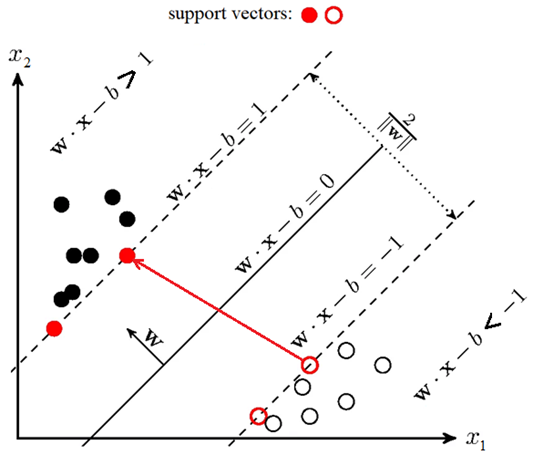

модель - линейный классификатор

$$a(x) = w^T\cdot x - b$$

метки классов 
$$y \in \{-1,+1\}$$

margine (отступ)

$$ M = y\cdot ( w^T x - b )$$

$\langle x,w\rangle - b = 0 $ - разделяющая гиперплоскость


$\langle x_+,w\rangle - b > 1$ - для позитивно размеченных объектов


$\langle x_-,w\rangle - b < -1$ - для негативно размеченных объектов





максимизация отступов

$$\langle x_+,w\rangle/ \|w\| = b + 1$$

$$\langle x_-,w\rangle/ \|w\| = b - 1 $$

$$  
\left\langle x_+ - x_- ,\frac{w}{\|w\|}\right\rangle 
=\frac{\langle x_+,w\rangle  - \langle x_-,w\rangle}{\|w\|} 
=\frac{ (b+1)  - (b-1)}{\|w\|} 
=\frac{2}{\|w\|} 
$$

$$2/ \|w\| \rightarrow max $$ 

$$\|w\| \rightarrow min$$


$$
w^T\cdot w \rightarrow min 
$$

если $ M<0 $ то ошибка классификации 

условие правильной классификации
$$ y\cdot ( w^T x - b )\geq 1$$

Если объединить два выведенных выражения, то получим дефолтную настройку SVM с жестким зазором (hard-margin SVM), когда никакому объекту не разрешается попадать на полосу разделения. Решается аналитически через теорему Куна-Таккера. Получаемая задача эквивалентна двойственной задаче поиска седловой точки функции Лагранжа.

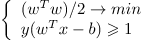

---

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

from sklearn.datasets import make_moons
X,target = make_moons(n_samples=n_samples, noise=.09)

y = target# [:,np.newaxis]

X.shape, y.shape

((500, 2), (500,))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [7]:
del X
del y
del target

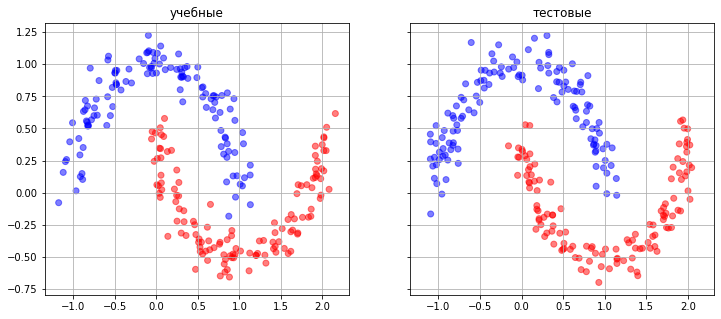

In [8]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

## обучаем модель

https://scikit-learn.org/stable/modules/svm.html

In [9]:
from sklearn import svm
model = svm.SVC( probability=True ).fit(X_train, y_train)

In [10]:
# svm.SVC?

In [11]:
# svm.SVC(
#     *,
#     C=1.0,
#     kernel='rbf',
#     degree=3,
#     gamma='scale',
#     coef0=0.0,
#     shrinking=True,
#     probability=False,
#     tol=0.001,
#     cache_size=200,
#     class_weight=None,
#     verbose=False,
#     max_iter=-1,
#     decision_function_shape='ovr',
#     break_ties=False,
#     random_state=None,
# )

## тестируем модель

In [12]:
s = model.predict_proba(X_test)[:,1]

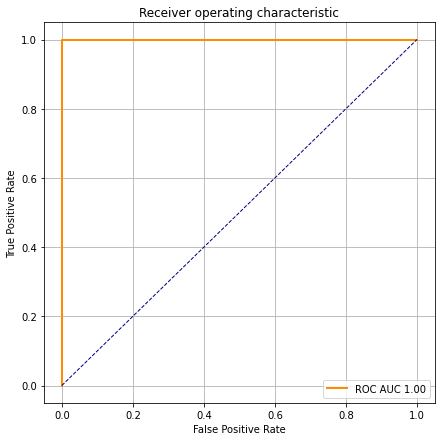

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test, s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.8077136018279912

In [15]:
p = (s>optimal_threshold).astype(int)
y = (y_test>0).astype(int)

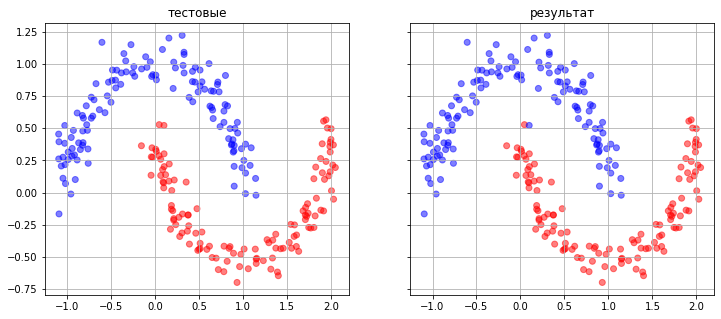

In [16]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       127
           1       1.00      0.99      1.00       123

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



## карта скоров

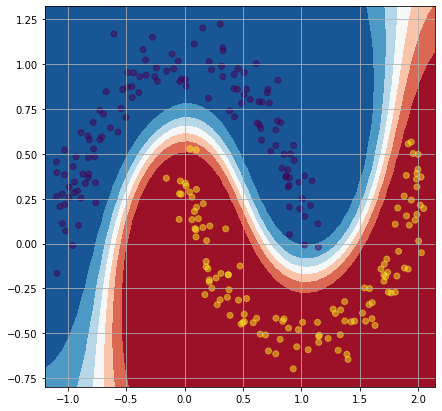

In [18]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
 
s = model.predict_proba(xy)[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5 )
plt.grid()